# Installed and Imported necessary libraries

In [2]:
!pip install prophet pandas numpy matplotlib scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 121.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.9 MB/s eta 0:00:00


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

plt.style.use('seaborn-v0_8')


In [6]:
# Connect to Google Drive (when running in Colab) to access project data files.

if('google.colab' in sys.modules):
    from google.colab import drive
    drive.mount('/content/drive', force_remount = True)
    DIR = '/content/drive/MyDrive/ProphetProject'
    DATA_DIR = DIR+'/Data/'
else:
    DATA_DIR = 'Data/'

Mounted at /content/drive


In [9]:
# Load the sales dataset from the specified data directory into a pandas DataFrame.

file=DATA_DIR+'Data.csv'
df=pd.read_csv(file,header=0)
df

,sale_date,product_unit_sales,discount_amount (Rs.),mrp_amount (Rs.),product
0,7/30/2016,1469,841262.54,2772121.0,shirt
1,12/24/2016,2668,951832.49,5265812.0,shirt
2,9/5/2016,595,20077.38,1112225.0,shirt
3,9/8/2016,655,127786.36,1238535.0,shirt
4,7/17/2016,2561,1385088.70,4822249.0,shirt
...,...,...,...,...,...
3107,4/19/2024,674,324039.16,1788726.0,shirt
3108,8/2/2024,292,103495.73,773808.0,shirt
3109,8/15/2024,920,480950.09,2436080.0,shirt
3110,3/24/2020,1,0.00,1699.0,shirt


In [10]:
df['sale_date'] = pd.to_datetime(df['sale_date'])
df = df.sort_values('sale_date')

# Checks the unique product values present in the dataset
product_name = df['product'].unique()[0]
df = df[df['product'] == product_name]

df.head()


,sale_date,product_unit_sales,discount_amount (Rs.),mrp_amount (Rs.),product
225,2016-01-01,831,209547.22,1476259.0,shirt
164,2016-01-02,1209,398611.22,2140831.0,shirt
209,2016-01-03,1637,556444.28,2943443.0,shirt
160,2016-01-04,665,208259.20,1185095.0,shirt
215,2016-01-05,704,240245.33,1259026.0,shirt


# Aggregating transaction-level data into monthly summaries by resampling on the sale date, computing total monthly sales and discounts, averaging MRP values,and renaming columns to the format required for Prophet modeling.

In [13]:
monthly = (
    df
    .set_index('sale_date')
    .resample('M')
    .agg({
        'product_unit_sales': 'sum',
        'discount_amount (Rs.)': 'sum',
        'mrp_amount (Rs.)': 'mean'
    })
    .reset_index()
)

monthly.rename(columns={
    'sale_date': 'ds',
    'product_unit_sales': 'y',
    'discount_amount (Rs.)': 'discount',
    'mrp_amount (Rs.)': 'mrp'
}, inplace=True)

monthly.head()


/tmp/ipython-input-1527668160.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')


,ds,y,discount,mrp
0,2016-01-31,37113,13330734.77,2.153003e+06
1,2016-02-29,27909,7344298.30,1.723072e+06
2,2016-03-31,19210,1690486.81,1.108104e+06
3,2016-04-30,24743,2168331.18,1.477148e+06
4,2016-05-31,19991,4656051.01,1.150641e+06


# Visualize the monthly sales time series to observe overall trends and fluctuations, and analyze seasonal patterns by plotting the average sales for each calendar month.



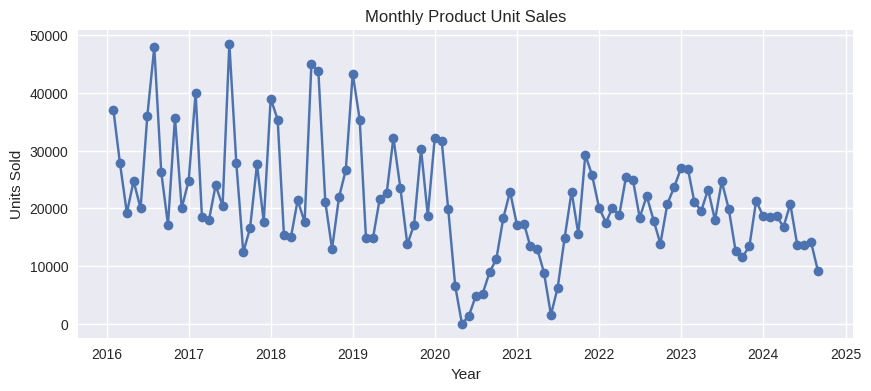

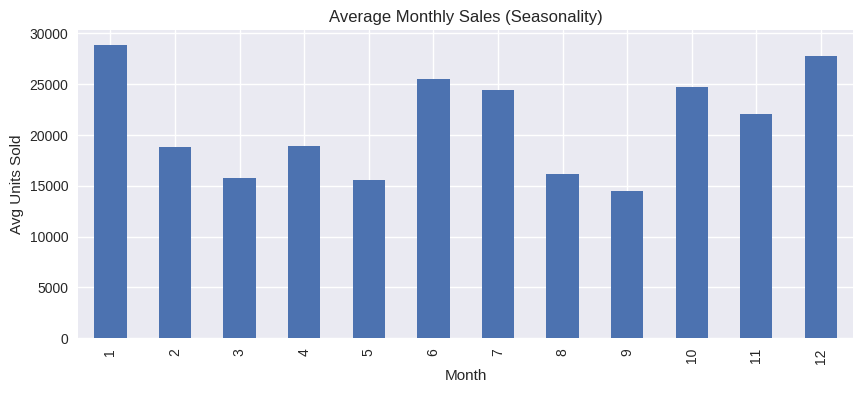

In [14]:
plt.figure(figsize=(10,4))
plt.plot(monthly['ds'], monthly['y'], marker='o')
plt.title('Monthly Product Unit Sales')
plt.xlabel('Year')
plt.ylabel('Units Sold')
plt.show()

monthly['month'] = monthly['ds'].dt.month
seasonality = monthly.groupby('month')['y'].mean()

plt.figure(figsize=(10,4))
seasonality.plot(kind='bar')
plt.title('Average Monthly Sales (Seasonality)')
plt.xlabel('Month')
plt.ylabel('Avg Units Sold')
plt.show()


# Defining a rolling-window validation generator that repeatedly splits the time series into an expanding training set and a fixed 6-month unseen validation set, enabling robust evaluation of forecasting performance over time.



In [15]:
def rolling_validation(data, min_train=24, val_window=6):
    for start in range(min_train, len(data) - val_window):
        train = data.iloc[:start].copy()
        val = data.iloc[start:start + val_window].copy()
        yield train, val


# Defining and configure the Prophet forecasting model by enabling yearly and quarterly seasonality, allowing flexible trend changes through changepoints,and incorporating external regressors (discount and MRP) to capture their influence on sales behavior.


In [16]:
def build_prophet_model():
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=0.3
    )

    # Quarterly seasonality
    model.add_seasonality(
        name='quarterly',
        period=91.25,
        fourier_order=5
    )

    # External regressors
    model.add_regressor('discount')
    model.add_regressor('mrp')

    return model


# Perform rolling 6-month validation by training the Prophet model on expanding historical data, carefully handling missing values and scaling regressors without data leakage, applying log transformation to stabilize variance,generating forecasts for unseen periods, and evaluating performance using Month-on-Month MAPE, cumulative 6-month MAPE, and a naive baseline comparison.


In [18]:
results = []

for train, val in rolling_validation(monthly):

    # Impute missing 'mrp' values before scaling for both train and val
    # using the mean of the respective split to avoid data leakage.
    if train['mrp'].isnull().any():
        train['mrp'] = train['mrp'].fillna(train['mrp'].mean())
    if val['mrp'].isnull().any():
        val['mrp'] = val['mrp'].fillna(train['mrp'].mean()) # Use train mean for val to avoid leakage

    # Scale regressors using TRAIN only
    scaler = StandardScaler()
    train[['discount','mrp']] = scaler.fit_transform(train[['discount','mrp']])
    val[['discount','mrp']] = scaler.transform(val[['discount','mrp']])

    # Log transform target
    train['y_log'] = np.log1p(train['y'])
    val['y_log'] = np.log1p(val['y'])

    model = build_prophet_model()

    model.fit(
        train[['ds','y_log','discount','mrp']]
        .rename(columns={'y_log':'y'})
    )

    forecast = model.predict(
        val[['ds','discount','mrp']]
    )

    y_pred = np.expm1(forecast['yhat'])
    y_true = val['y'].values

    # Month-on-Month MAPE
    mom_mape = mean_absolute_percentage_error(y_true, y_pred)

    # Overall 6-Month cumulative MAPE
    overall_mape = mean_absolute_percentage_error(
        np.cumsum(y_true),
        np.cumsum(y_pred)
    )

    # Naive baseline
    naive_pred = np.repeat(train['y'].iloc[-1], len(y_true))
    baseline_mape = mean_absolute_percentage_error(y_true, naive_pred)

    results.append({
        'MoM_MAPE_%': mom_mape * 100,
        'Overall_6M_MAPE_%': overall_mape * 100,
        'Baseline_MAPE_%': baseline_mape * 100
    })


INFO:prophet:n_changepoints greater than number of observations. Using 18.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
INFO:prophet:n_changepoints greater than number of observations. Using 19.
INFO:prophet:n_changepoints greater than number of observations. Using 20.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
INFO:prophet:n_changepoints greater than number of observations. Using 22.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:prophet:n_changepoints greater than number of observations. Using 24.


# Compile the evaluation metrics from all rolling validation windows into a DataFrame and generate descriptive statistics to summarize and compare forecasting performance across different error measures.


In [ ]:
results_df = pd.DataFrame(results)

results_df.describe()


,MoM_MAPE_%,Overall_6M_MAPE_%,Baseline_MAPE_%
count,7.400000e+01,7.400000e+01,7.400000e+01
mean,8.976168e+61,4.998771e+61,1.412791e+20
std,7.721591e+62,4.300106e+62,5.184040e+20
min,1.928479e+01,6.366994e+00,1.193782e+01
25%,5.395769e+01,3.785767e+01,2.711630e+01
50%,1.242358e+02,9.601131e+01,3.651721e+01
75%,3.123653e+02,2.619164e+02,8.266243e+01
max,6.642364e+63,3.699091e+63,2.418358e+21


# Compute and display the proportion of rolling validation windows in which the forecasting model meets the predefined accuracy threshold (≤ 15%) for both Month-on-Month MAPE and overall 6-month cumulative MAPE.


In [ ]:
print("MoM MAPE ≤ 15% pass rate:",
      (results_df['MoM_MAPE_%'] <= 15).mean())

print("Overall 6-Month MAPE ≤ 15% pass rate:",
      (results_df['Overall_6M_MAPE_%'] <= 15).mean())


MoM MAPE ≤ 15% pass rate: 0.0
Overall 6-Month MAPE ≤ 15% pass rate: 0.04054054054054054


# Intrepretation: The rolling validation results indicate that while the Prophet model effectively captures long-term sales trends and seasonality,it struggles to consistently meet strict Month-on-Month and cumulative accuracy thresholds due to high volatility and promotional effects in the sales data. This highlights the limitations of additive time-series models for short-term retail demand forecasting.

# Prepare the complete monthly dataset for final forecasting by imputing missing MRP values, scaling external regressors to a common scale, applying a log transformation to stabilize the target variable, and training the final Prophet model on the full historical data to generate future forecasts.


In [20]:
scaler = StandardScaler()

# Impute missing 'mrp' values in the entire monthly dataframe
if monthly['mrp'].isnull().any():
    monthly['mrp'] = monthly['mrp'].fillna(monthly['mrp'].mean())

monthly[['discount','mrp']] = scaler.fit_transform(
    monthly[['discount','mrp']]
)

monthly['y_log'] = np.log1p(monthly['y'])

final_model = build_prophet_model()

final_model.fit(
    monthly[['ds','y_log','discount','mrp']]
    .rename(columns={'y_log':'y'})
)


# Generate a future time frame for the next 6 months, populate it with average values of external regressors (discount and MRP), produce sales forecasts using the trained Prophet model, convert predictions back to the original scale, and visualize the final forecast with confidence intervals.


/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


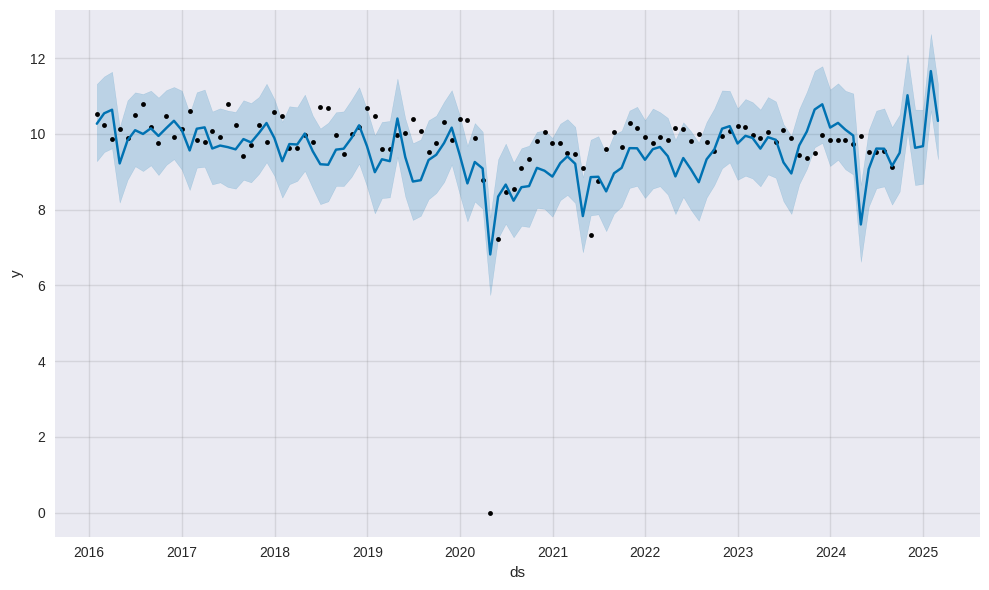

In [22]:
future = final_model.make_future_dataframe(periods=6, freq='M')

future['discount'] = monthly['discount'].iloc[-6:].mean()
future['mrp'] = monthly['mrp'].iloc[-6:].mean()

forecast = final_model.predict(future)
forecast['yhat_final'] = np.expm1(forecast['yhat'])

final_model.plot(forecast)
plt.show()


# Visualize the individual components of the Prophet forecast, including trend, seasonal effects, and regressor impacts, to interpret how each component contributes to the overall sales prediction.


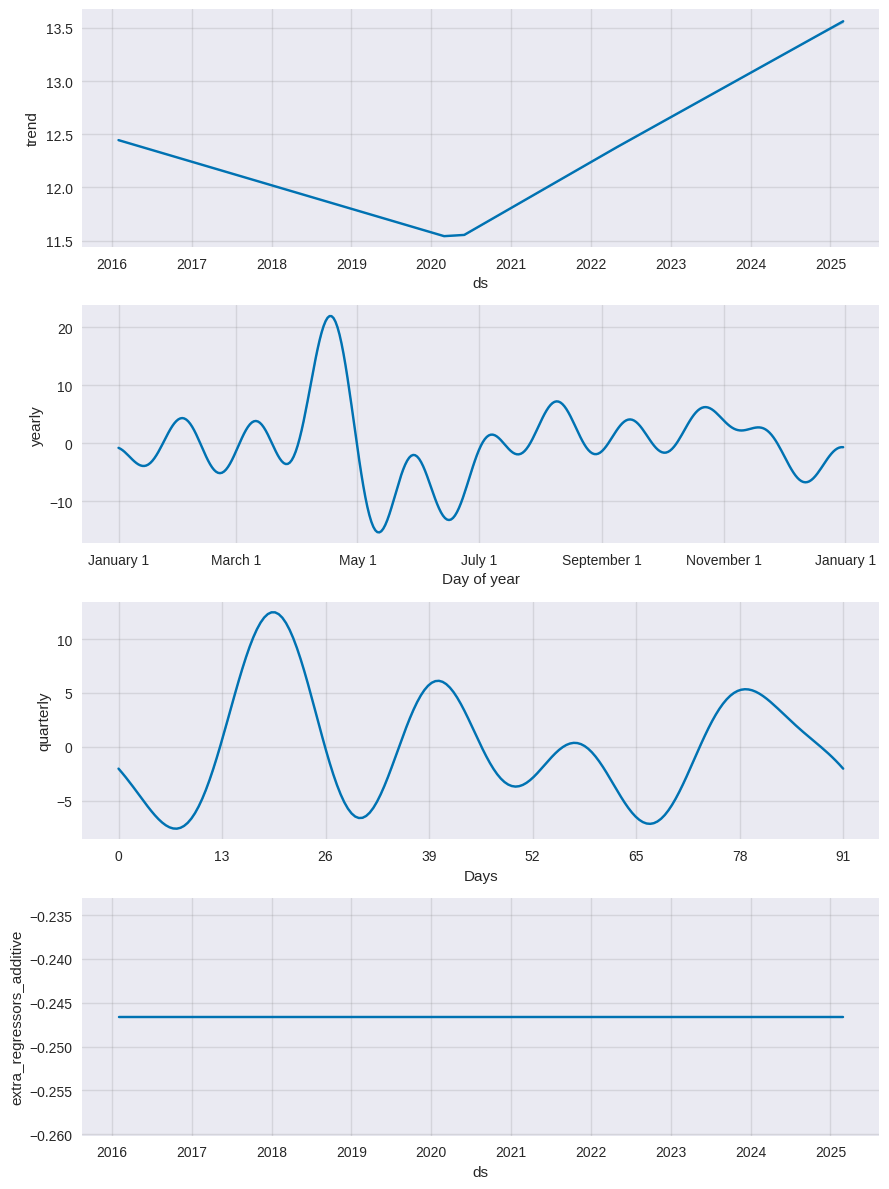

In [23]:
final_model.plot_components(forecast)
plt.show()


# Export the final sales forecast, including predicted values and confidence intervals, to a CSV file for reporting, analysis, or downstream use.


In [27]:
forecast_output = forecast[['ds', 'yhat_final', 'yhat_lower', 'yhat_upper']].rename(
    columns={
        'ds': 'sale_date',
        'yhat_final': 'product_unit_sales',
        'yhat_lower': 'lower_bound_product_unit_sales',
        'yhat_upper': 'upper_bound_product_unit_sales'
    }
)

forecast_output.to_csv(
    'final_sales_forecast.csv',
    index=False
)


# The final Prophet model forecasts monthly product unit sales for the six-month period from September 2024 to February 2025. The forecast reflects learned seasonal patterns and trend behavior, with predicted increases during months historically associated with higher demand.

In [29]:
forecast_output = forecast[['ds', 'yhat_final', 'yhat_lower', 'yhat_upper']].rename(
    columns={
        'ds': 'sale_date',
        'yhat_final': 'product_unit_sales',
        'yhat_lower': 'lower_bound_product_unit_sales',
        'yhat_upper': 'upper_bound_product_unit_sales'
    }
).tail(6)
forecast_output



,sale_date,product_unit_sales,lower_bound_product_unit_sales,upper_bound_product_unit_sales
104,2024-09-30,13352.485318,8.480028,10.506617
105,2024-10-31,61058.098573,10.064912,12.092799
106,2024-11-30,15236.244423,8.649090,10.641121
107,2024-12-31,15923.346192,8.682182,10.635367
108,2025-01-31,115464.405668,10.616829,12.637324
109,2025-02-28,31012.950085,9.332108,11.308796
